In [15]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv(
    "../../data/Acetylcholinesterase_human_IC50_ChEMBLBindingDB_spliton6_binary_1micromolar.csv"
)
df.head()

,SMILES,InChI,chem-id,chem-name,single-class-label
0,CN(C)C(=O)Oc1cccc([N+](C)(C)C)c1,InChI=1S/C12H19N2O2/c1-13(2)12(15)16-11-8-6-7-...,CHEMBL54126,NEOSTIGMINE BROMIDE,1
1,O=C(CCCCC1CCSS1)NCCCNc1c2c(nc3cc(Cl)ccc13)CCCC2,InChI=1S/C24H32ClN3OS2/c25-17-10-11-20-22(16-1...,CHEMBL194823,LIPOCRINE,1
2,COc1cc2c(cc1OC)C(=O)C(CC1CCN(CCCNc3c4c(nc5cc(C...,InChI=1S/C33H40ClN3O3/c1-39-30-18-22-17-23(33(...,CHEMBL3216655,NaN,1
3,CNC(=O)Oc1cccc(CN(C)CCCOc2ccc3c(=O)c4ccccc4oc3...,InChI=1S/C26H26N2O5/c1-27-26(30)32-20-8-5-7-18...,CHEMBL340427,XANTHOSTIGMINE,1
4,CCC1=CC2Cc3nc4cc(Cl)ccc4c(N)c3[C@@H](C1)C2,InChI=1S/C18H19ClN2/c1-2-10-5-11-7-12(6-10)17-...,CHEMBL208599,HUPRINE X,1


In [5]:
fplen = 1024


def smiles2ecfp(smi):
    fpgen = AllChem.GetMorganGenerator(radius=3, fpSize=fplen)
    m1 = Chem.MolFromSmiles(smi)
    return fpgen.GetFingerprintAsNumPy(m1)


df["ecfp"] = df.apply(lambda row: smiles2ecfp(row["SMILES"]), axis=1)

### Identifying highly correlated bits

In [6]:
cols = [f'ECFP_Bit_{n}' for n in range(1024)]
fps = pd.DataFrame(df['ecfp'].tolist(), columns=cols)

In [7]:
threshold = 0.8
corr = fps.corr(numeric_only=True).abs()
high_corr = [
    (corr.index[x], corr.columns[y])
    for x, y in zip(*(np.where(corr > threshold)))
    if x != y and x < y
]
# TODO: larger groups & heatmap
print(high_corr)

[('ECFP_Bit_249', 'ECFP_Bit_946'), ('ECFP_Bit_304', 'ECFP_Bit_468'), ('ECFP_Bit_322', 'ECFP_Bit_718'), ('ECFP_Bit_468', 'ECFP_Bit_655'), ('ECFP_Bit_512', 'ECFP_Bit_841'), ('ECFP_Bit_549', 'ECFP_Bit_989')]


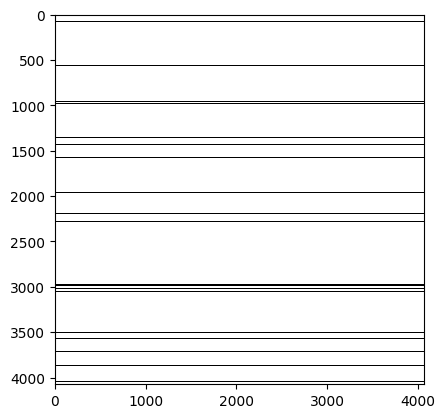

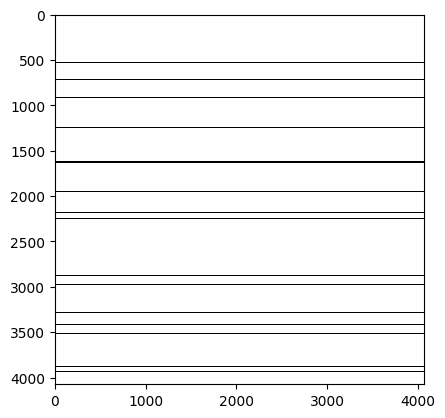

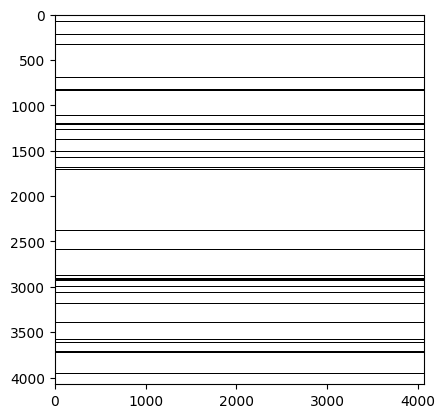

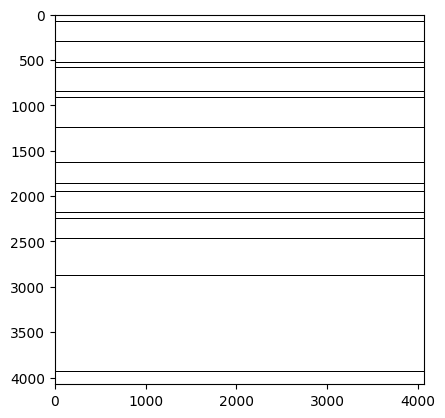

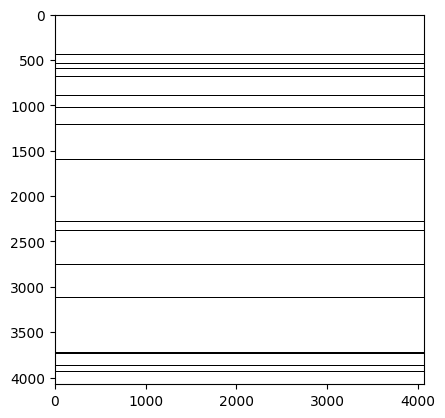

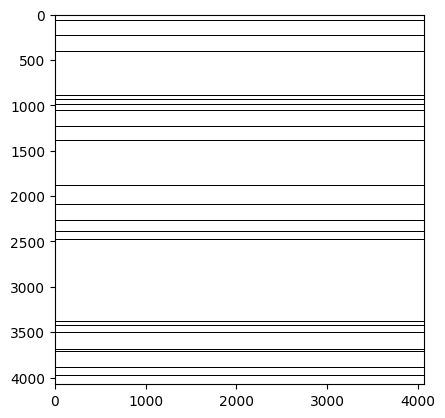

In [20]:
for bits in high_corr:
    pair = fps[list(bits)].copy()
    # generate heatmap
    hm = np.zeros((pair.shape[0], pair.shape[0], 3))
    hm[pair[bits[0]] == pair[bits[1]]] = [1, 1, 1]
    plt.imshow(hm, interpolation="nearest")
    plt.show()